# Training and Adapting Deep Networks with Limited Data

| Contribution   |
| :---   |
| Leonardo Villamil  |
| Litian Chen        |

In [2]:
import os
import numpy as np
import scipy.io
import pandas as pd
import visualkeras

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

In [3]:
def plot_eval_model(history, model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2);
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
        
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)

    cm = confusion_matrix(y_test, indexes, normalize='true')
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

## Load Data

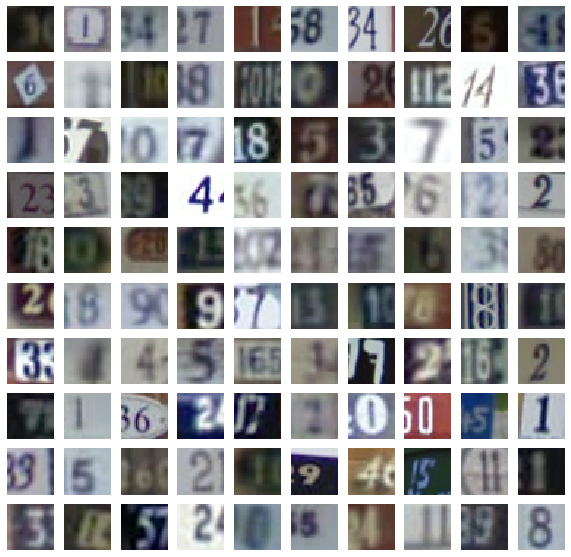

In [4]:
train = scipy.io.loadmat('Data/Q1/q1_train.mat')
test = scipy.io.loadmat('Data/Q1/q1_test.mat')

X_train = np.transpose(train['train_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3).astype('float32')/255
y_train = train['train_Y'].reshape(-1, 1)
y_train = np.where(y_train == 10, 0, y_train)
X_test = np.transpose(test['test_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3).astype('float32')/255
y_test = test['test_Y'].reshape(-1, 1)
y_test = np.where(y_test == 10, 0, y_test)

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(X_train[i,:,:,:])
    plt.axis("off")

Let's check for class balance

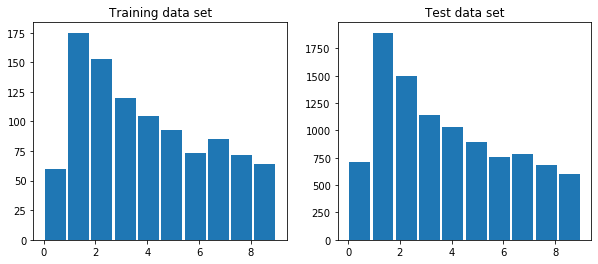

In [5]:
fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 2, 1)
ax.hist(y_train, bins=10, rwidth=0.9)
ax.set_title('Training data set')
ax = fig.add_subplot(1, 2, 2)
ax.hist(y_test, bins=10, rwidth=0.9)
ax.set_title('Test data set');

## CNN Model with No Data Augmentation

This first model will be based on the example of week 4

In [6]:
# our input now has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# more convolution, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final convolution, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
# a flatten layer. This make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation='relu')(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_1')
model_cnn.summary()

Model: "SVHN_cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 512)          

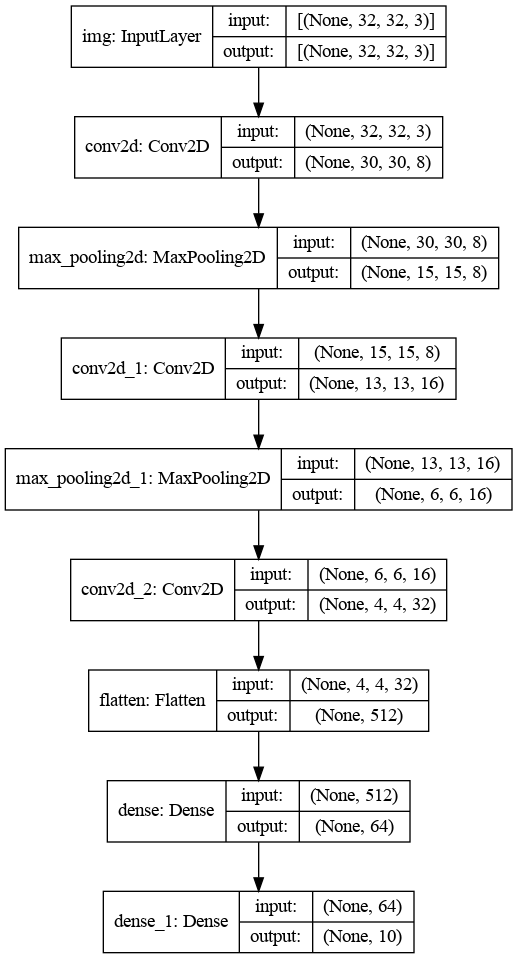

In [7]:
keras.utils.plot_model(model_cnn, show_shapes=True)

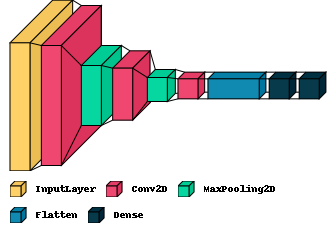

In [8]:
visualkeras.layered_view(model_cnn, legend=True)

In [9]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=80,
                        validation_data=(X_test, y_test))

Epoch 1/80
16/16 [==============================] - 2s 100ms/step - loss: 2.2923 - accuracy: 0.1230 - val_loss: 2.2366 - val_accuracy: 0.1894
Epoch 2/80
16/16 [==============================] - 1s 55ms/step - loss: 2.2353 - accuracy: 0.1741 - val_loss: 2.2420 - val_accuracy: 0.2214
Epoch 3/80
16/16 [==============================] - 1s 57ms/step - loss: 2.2272 - accuracy: 0.2350 - val_loss: 2.2208 - val_accuracy: 0.2139
Epoch 4/80
16/16 [==============================] - 1s 61ms/step - loss: 2.2217 - accuracy: 0.2233 - val_loss: 2.2038 - val_accuracy: 0.2216
Epoch 5/80
16/16 [==============================] - 1s 57ms/step - loss: 2.1931 - accuracy: 0.2047 - val_loss: 2.1774 - val_accuracy: 0.2209
Epoch 6/80
16/16 [==============================] - 1s 54ms/step - loss: 2.1487 - accuracy: 0.2261 - val_loss: 2.1210 - val_accuracy: 0.2327
Epoch 7/80
16/16 [==============================] - 1s 57ms/step - loss: 2.0966 - accuracy: 0.2473 - val_loss: 2.0246 - val_accuracy: 0.3103
Epoch 8/80
1

313/313 - 1s - loss: 1.5789 - accuracy: 0.7744
Test loss: 1.5789494514465332
Test accuracy: 0.774399995803833


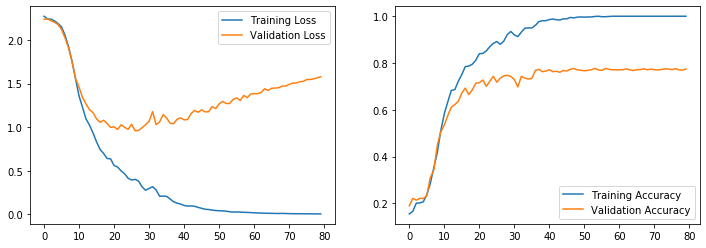

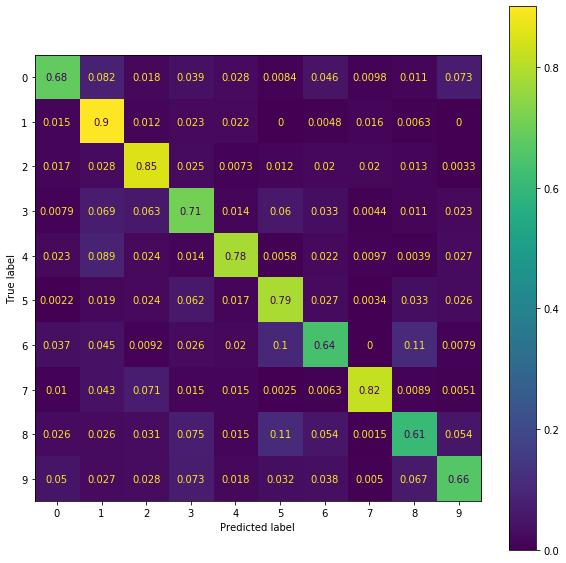

In [10]:
plot_eval_model(history, model_cnn, X_test, y_test)

Let's simplify the Net

In [11]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=2, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_2')
model_cnn.summary()

Model: "SVHN_cnn_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 2)         56        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 4)         76        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           296       
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)          

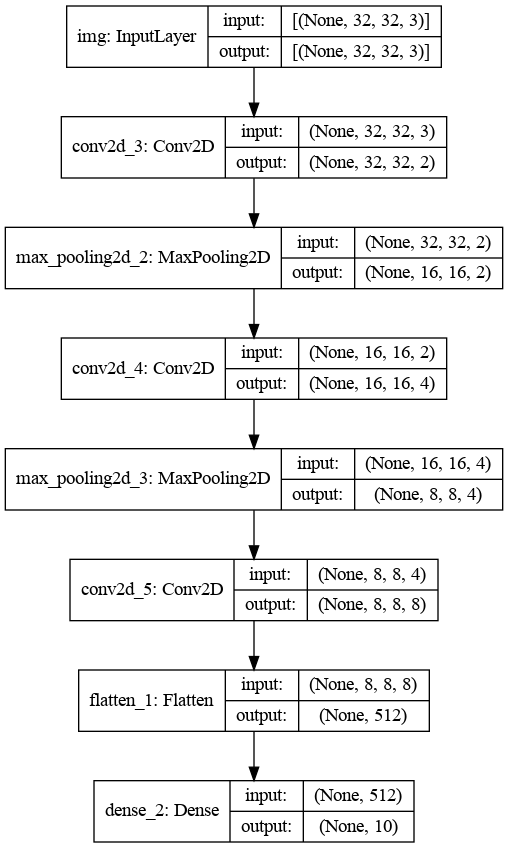

In [12]:
keras.utils.plot_model(model_cnn, show_shapes=True)

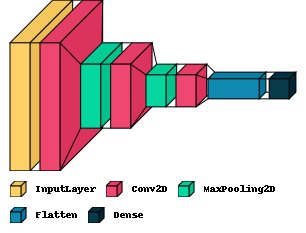

In [13]:
visualkeras.layered_view(model_cnn, legend=True)

In [14]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=150,
                        validation_data=(X_test, y_test))

ss: 1.9924 - accuracy: 0.3330 - val_loss: 2.0443 - val_accuracy: 0.3063
Epoch 12/150
16/16 [==============================] - 1s 81ms/step - loss: 1.9256 - accuracy: 0.3601 - val_loss: 2.0111 - val_accuracy: 0.3142
Epoch 13/150
16/16 [==============================] - 1s 81ms/step - loss: 1.8633 - accuracy: 0.3864 - val_loss: 1.9693 - val_accuracy: 0.3360
Epoch 14/150
16/16 [==============================] - 1s 83ms/step - loss: 1.7741 - accuracy: 0.4163 - val_loss: 1.9296 - val_accuracy: 0.3583
Epoch 15/150
16/16 [==============================] - 1s 81ms/step - loss: 1.7657 - accuracy: 0.4073 - val_loss: 1.9221 - val_accuracy: 0.3710
Epoch 16/150
16/16 [==============================] - 1s 78ms/step - loss: 1.6877 - accuracy: 0.4380 - val_loss: 1.8880 - val_accuracy: 0.3634
Epoch 17/150
16/16 [==============================] - 1s 82ms/step - loss: 1.6234 - accuracy: 0.4694 - val_loss: 1.8309 - val_accuracy: 0.3966
Epoch 18/150
16/16 [==============================] - 1s 81ms/step - l

313/313 - 1s - loss: 2.5114 - accuracy: 0.6839
Test loss: 2.5114316940307617
Test accuracy: 0.683899998664856


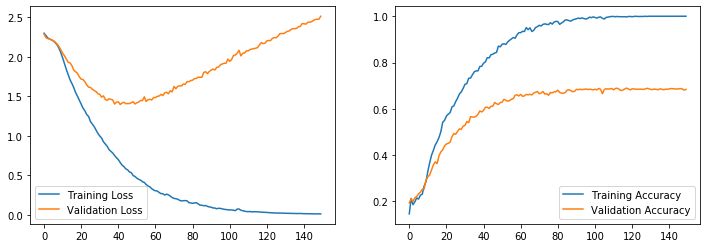

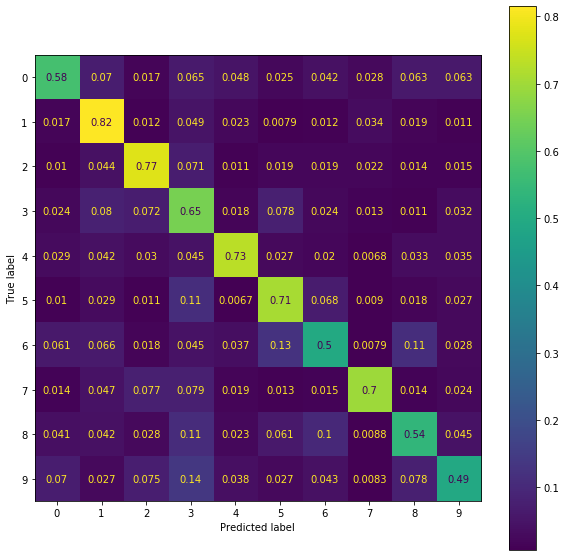

In [15]:
plot_eval_model(history, model_cnn, X_test, y_test)

In this example, we've reduced the capacity of the model. We've dramatically reduced the number of filters, so essentialy out model can't learn as much. The end result is that the model struggles to learn.

Let's try something more complex

In [16]:
# our input now has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# 2 - 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# Additional 2 convolutions, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final 2 extra convolutions, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
# a flatten layer. This make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation='relu')(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_3')
model_cnn.summary()

Model: "SVHN_cnn_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)     

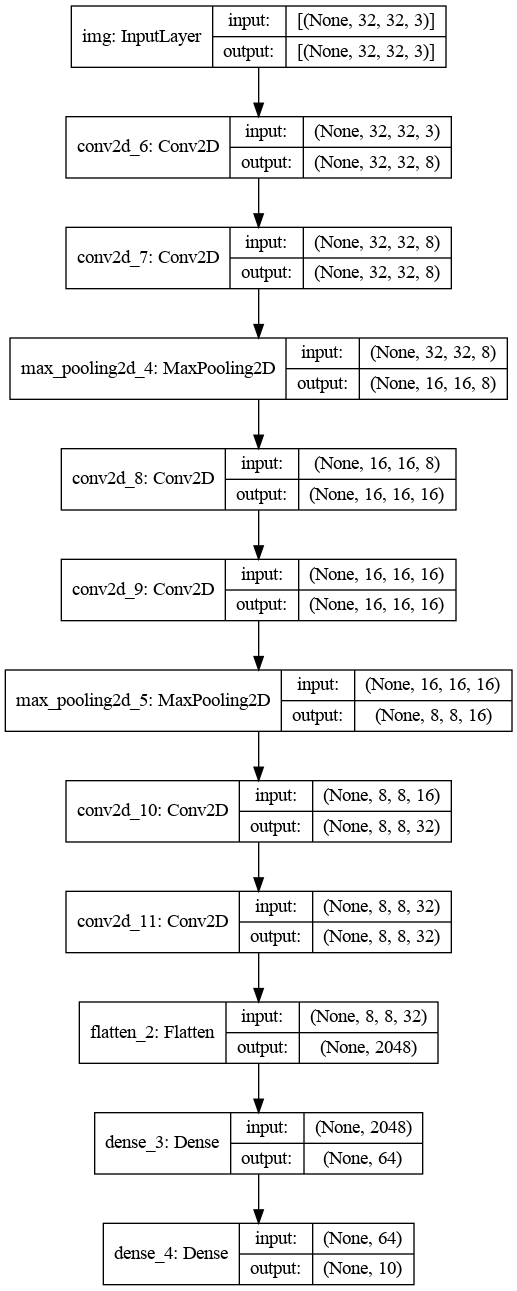

In [17]:
keras.utils.plot_model(model_cnn, show_shapes=True)

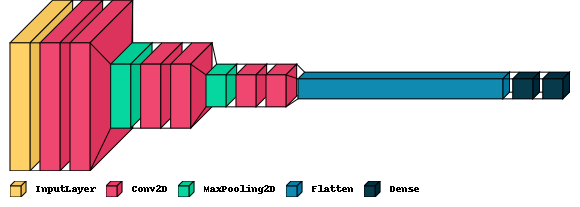

In [18]:
visualkeras.layered_view(model_cnn, legend=True)

In [19]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=50,
                        validation_data=(X_test, y_test))

Epoch 1/50
16/16 [==============================] - 3s 138ms/step - loss: 2.2906 - accuracy: 0.1238 - val_loss: 2.2550 - val_accuracy: 0.1894
Epoch 2/50
16/16 [==============================] - 2s 121ms/step - loss: 2.2538 - accuracy: 0.1801 - val_loss: 2.2388 - val_accuracy: 0.1894
Epoch 3/50
16/16 [==============================] - 2s 119ms/step - loss: 2.2406 - accuracy: 0.1802 - val_loss: 2.2438 - val_accuracy: 0.1905
Epoch 4/50
16/16 [==============================] - 2s 122ms/step - loss: 2.2363 - accuracy: 0.2006 - val_loss: 2.2258 - val_accuracy: 0.2082
Epoch 5/50
16/16 [==============================] - 2s 119ms/step - loss: 2.2353 - accuracy: 0.2205 - val_loss: 2.2049 - val_accuracy: 0.2228
Epoch 6/50
16/16 [==============================] - 2s 123ms/step - loss: 2.1934 - accuracy: 0.2368 - val_loss: 2.1623 - val_accuracy: 0.2299
Epoch 7/50
16/16 [==============================] - 2s 119ms/step - loss: 2.0747 - accuracy: 0.2673 - val_loss: 1.9515 - val_accuracy: 0.3299
Epoch 

313/313 - 2s - loss: 2.5176 - accuracy: 0.7392
Test loss: 2.517573595046997
Test accuracy: 0.7391999959945679


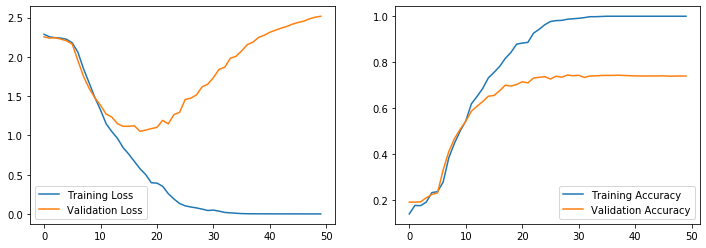

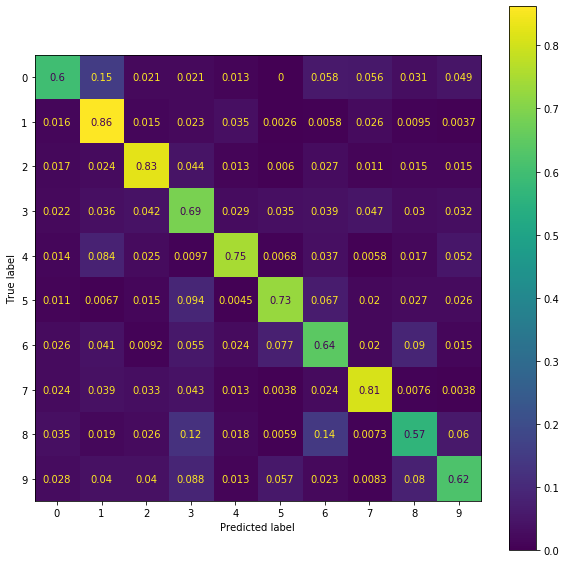

In [20]:
plot_eval_model(history, model_cnn, X_test, y_test)

This has lead to a clear case of overfitting.

Let's try to imrpove this by appying  Dropout, batch normalization, and regularization

In [21]:
# our input now has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# 2 - 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(inputs)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# Additional 2 convolutions, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final 2 extra convolutions, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
# a flatten layer. This make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation=None,  kernel_regularizer='l1')(x)
x = layers.Activation(activations.relu)(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_4')
model_cnn.summary()

Model: "SVHN_cnn_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 8)    

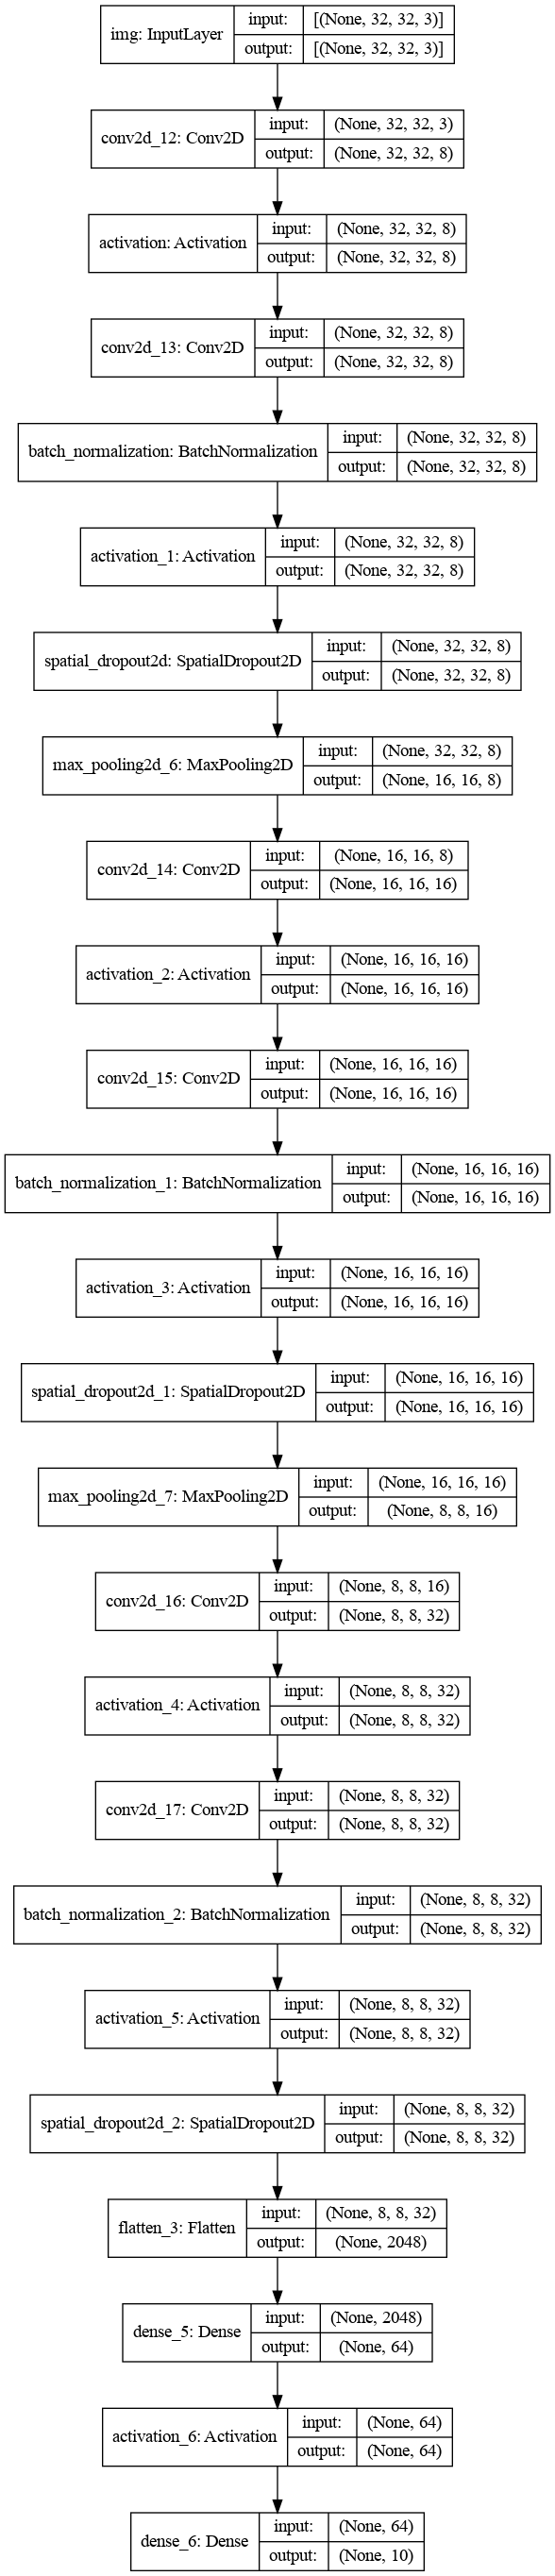

In [22]:
keras.utils.plot_model(model_cnn, show_shapes=True)

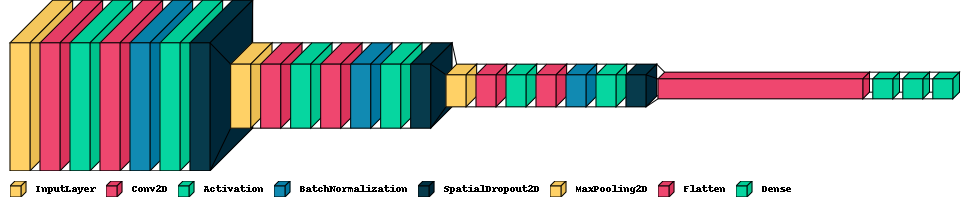

In [23]:
visualkeras.layered_view(model_cnn, legend=True)

In [24]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=150,
                        validation_data=(X_test, y_test))

 - loss: 2.4696 - accuracy: 0.4399 - val_loss: 2.9590 - val_accuracy: 0.1895
Epoch 13/150
16/16 [==============================] - 2s 143ms/step - loss: 2.3089 - accuracy: 0.5011 - val_loss: 2.8762 - val_accuracy: 0.2102
Epoch 14/150
16/16 [==============================] - 2s 143ms/step - loss: 2.2354 - accuracy: 0.5185 - val_loss: 2.8294 - val_accuracy: 0.2101
Epoch 15/150
16/16 [==============================] - 2s 144ms/step - loss: 2.2049 - accuracy: 0.5524 - val_loss: 2.8040 - val_accuracy: 0.2618
Epoch 16/150
16/16 [==============================] - 2s 146ms/step - loss: 2.1564 - accuracy: 0.5302 - val_loss: 2.7383 - val_accuracy: 0.2504
Epoch 17/150
16/16 [==============================] - 2s 159ms/step - loss: 2.1595 - accuracy: 0.5709 - val_loss: 2.7367 - val_accuracy: 0.2611
Epoch 18/150
16/16 [==============================] - 2s 143ms/step - loss: 2.0672 - accuracy: 0.5656 - val_loss: 2.5347 - val_accuracy: 0.4674
Epoch 19/150
16/16 [==============================] - 2s 16

313/313 - 2s - loss: 1.0977 - accuracy: 0.8128
Test loss: 1.0976554155349731
Test accuracy: 0.8127999901771545


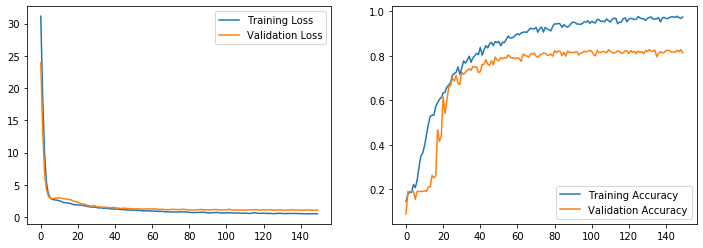

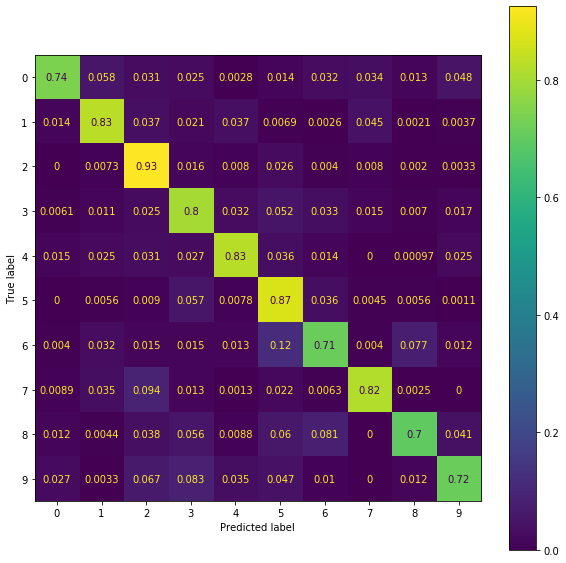

In [25]:
plot_eval_model(history, model_cnn, X_test, y_test)

## Data Augmentation

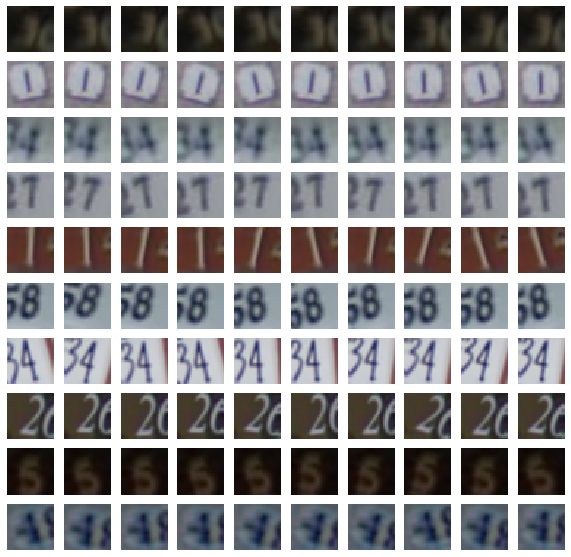

In [5]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.025, 0.025)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(0.05), width_factor=(0.05))
])

fig = plt.figure(figsize=[10, 10])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(X_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

## CNN Model with Data Augmentation

In [6]:
# our input now has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation(inputs)
# 2 - 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(augmented)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# Additional 2 convolutions, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final 2 extra convolutions, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.SpatialDropout2D(0.2)(x)
# a flatten layer. This make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation=None,  kernel_regularizer='l1')(x)
x = layers.Activation(activations.relu)(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn2 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_5')
model_cnn2.summary()

Model: "SVHN_cnn_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 8)    

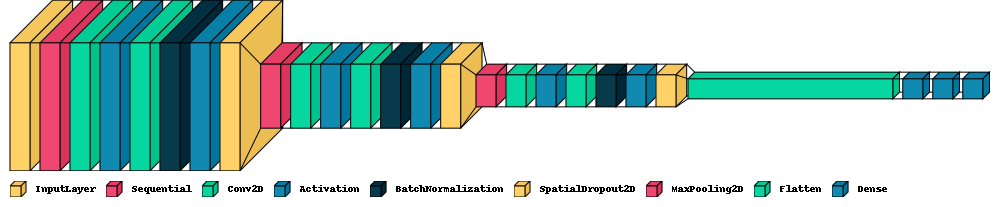

In [7]:
visualkeras.layered_view(model_cnn2, legend=True)

In [8]:
model_cnn2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn2.fit(X_train, y_train,
                        batch_size=64,
                        epochs=250,
                        validation_data=(X_test, y_test))

250
16/16 [==============================] - 2s 135ms/step - loss: 1.0573 - accuracy: 0.8356 - val_loss: 1.0860 - val_accuracy: 0.8527
Epoch 114/250
16/16 [==============================] - 2s 135ms/step - loss: 1.0353 - accuracy: 0.8496 - val_loss: 1.0349 - val_accuracy: 0.8540
Epoch 115/250
16/16 [==============================] - 2s 134ms/step - loss: 1.0352 - accuracy: 0.8611 - val_loss: 1.0315 - val_accuracy: 0.8572
Epoch 116/250
16/16 [==============================] - 2s 133ms/step - loss: 0.9903 - accuracy: 0.8716 - val_loss: 1.0259 - val_accuracy: 0.8577
Epoch 117/250
16/16 [==============================] - 2s 132ms/step - loss: 1.0093 - accuracy: 0.8469 - val_loss: 1.0284 - val_accuracy: 0.8554
Epoch 118/250
16/16 [==============================] - 2s 135ms/step - loss: 1.0170 - accuracy: 0.8544 - val_loss: 1.0360 - val_accuracy: 0.8530
Epoch 119/250
16/16 [==============================] - 2s 133ms/step - loss: 1.0763 - accuracy: 0.8457 - val_loss: 1.0600 - val_accuracy: 0.

313/313 - 2s - loss: 0.9748 - accuracy: 0.8748
Test loss: 0.9748299717903137
Test accuracy: 0.8748000264167786


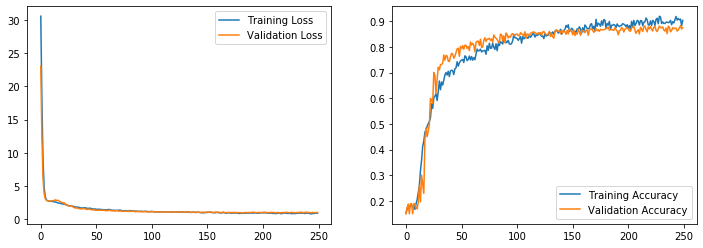

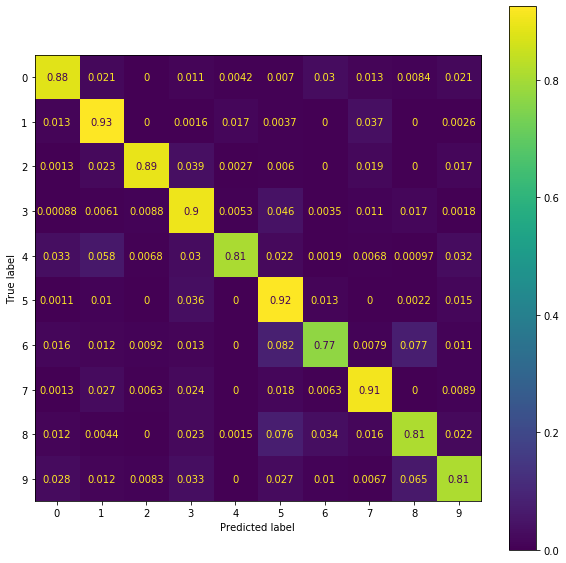

In [9]:
plot_eval_model(history, model_cnn2, X_test, y_test)

## Fine Tuning + Data Augmentation

In [10]:
model_cnn3 = keras.models.load_model('../Models/vggmodels_python/vgg_3stage_CIFAR_small.h5')
model_cnn3.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_24 (Spatia (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 8)         0

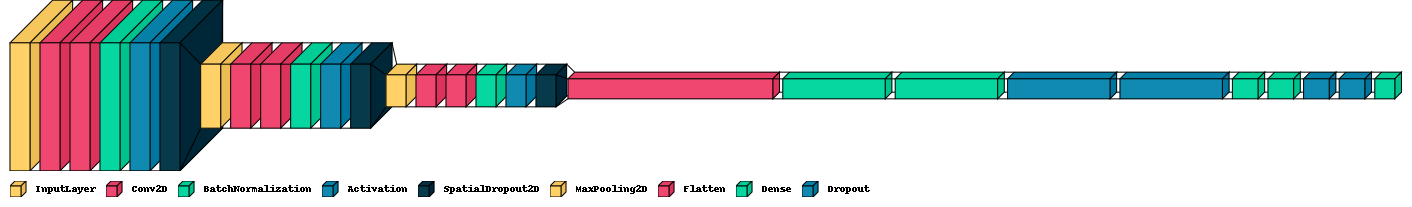

In [11]:
visualkeras.layered_view(model_cnn3, legend=True)

In [12]:
# remove first layer, i.e. the input
model_cnn3.layers.pop(0)

# our input has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation(inputs)

# pass the augmented input to the rest of the model
outputs = model_cnn3(augmented)

# build the model, and print the summary
model_cnn3 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_6')
model_cnn3.summary()

Model: "SVHN_cnn_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
simple_vgg (Functional)      (None, 10)                2386674   
Total params: 2,386,674
Trainable params: 2,384,002
Non-trainable params: 2,672
_________________________________________________________________


Here we increase the batch size due to icreased complexity of the model.

Note that here, I'm not using a particular small learning rate, but have just switched optimisers. Why? So that I can train fast. Basically I'm taking the risk that I'll undo some of the good work of my earlier model so that I can get my data to fit quicker due to computational constrains.

In [13]:
model_cnn3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn3.fit(X_train, y_train,
                        batch_size=64,
                        epochs=300,
                        validation_data=(X_test, y_test))

300
16/16 [==============================] - 3s 206ms/step - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.5810 - val_accuracy: 0.8597
Epoch 164/300
16/16 [==============================] - 3s 198ms/step - loss: 0.0541 - accuracy: 0.9811 - val_loss: 0.6014 - val_accuracy: 0.8578
Epoch 165/300
16/16 [==============================] - 3s 211ms/step - loss: 0.0655 - accuracy: 0.9773 - val_loss: 0.5685 - val_accuracy: 0.8599
Epoch 166/300
16/16 [==============================] - 3s 196ms/step - loss: 0.0288 - accuracy: 0.9963 - val_loss: 0.5692 - val_accuracy: 0.8624
Epoch 167/300
16/16 [==============================] - 4s 276ms/step - loss: 0.0386 - accuracy: 0.9913 - val_loss: 0.5977 - val_accuracy: 0.8640
Epoch 168/300
16/16 [==============================] - 4s 247ms/step - loss: 0.0440 - accuracy: 0.9849 - val_loss: 0.5899 - val_accuracy: 0.8611
Epoch 169/300
16/16 [==============================] - 3s 208ms/step - loss: 0.0424 - accuracy: 0.9910 - val_loss: 0.6024 - val_accuracy: 0.

313/313 - 2s - loss: 0.6583 - accuracy: 0.8644
Test loss: 0.6582643985748291
Test accuracy: 0.8644000291824341


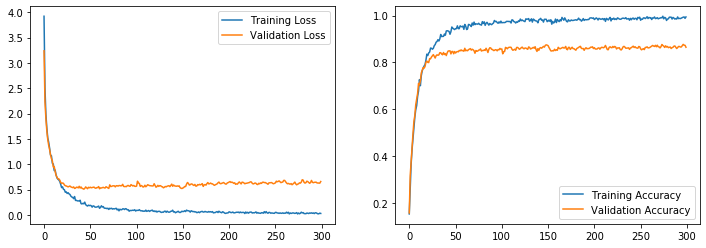

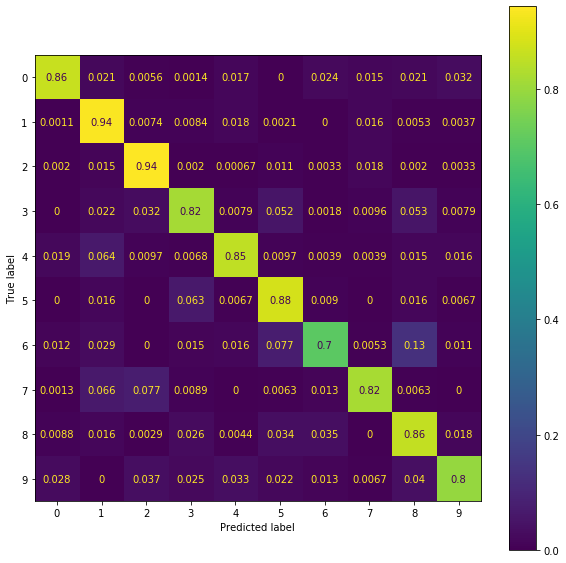

In [14]:
plot_eval_model(history, model_cnn3, X_test, y_test)

In [15]:
model_cnn3 = keras.models.load_model('../Models/vggmodels_python/vgg_3stage_CIFAR_small.h5')
# model_cnn3.summary()

# Freeze the layers except the last 9 layers
for layer in model_cnn3.layers[:-9]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_cnn3.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdb387e91f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb387e98b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb3aa9a100> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb3aaa1850> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb617d0be0> False
<tensorflow.python.keras.layers.core.SpatialDropout2D object at 0x7fdb3aae1640> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdb3aa918b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb3aa911c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb3aa91d30> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb3aa94d00> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb3869db20> False
<tensorflow.python.keras.layers.core.Spati

In [16]:
# remove first layer, i.e. the input
model_cnn3.layers.pop(0)

# our input has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation(inputs)

# pass the augmented input to the rest of the model
outputs = model_cnn3(augmented)

# build the model, and print the summary
model_cnn3 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_7')
model_cnn3.summary()

Model: "SVHN_cnn_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
simple_vgg (Functional)      (None, 10)                2386674   
Total params: 2,386,674
Trainable params: 2,365,706
Non-trainable params: 20,968
_________________________________________________________________


In [17]:
model_cnn3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn3.fit(X_train, y_train,
                        batch_size=64,
                        epochs=300,
                        validation_data=(X_test, y_test))

300
16/16 [==============================] - 2s 149ms/step - loss: 0.2143 - accuracy: 0.9287 - val_loss: 0.9368 - val_accuracy: 0.7684
Epoch 164/300
16/16 [==============================] - 2s 161ms/step - loss: 0.1974 - accuracy: 0.9393 - val_loss: 0.9571 - val_accuracy: 0.7699
Epoch 165/300
16/16 [==============================] - 2s 151ms/step - loss: 0.1717 - accuracy: 0.9437 - val_loss: 0.9955 - val_accuracy: 0.7679
Epoch 166/300
16/16 [==============================] - 2s 150ms/step - loss: 0.2444 - accuracy: 0.9202 - val_loss: 0.9561 - val_accuracy: 0.7722
Epoch 167/300
16/16 [==============================] - 2s 150ms/step - loss: 0.2106 - accuracy: 0.9386 - val_loss: 0.9437 - val_accuracy: 0.7722
Epoch 168/300
16/16 [==============================] - 2s 150ms/step - loss: 0.2440 - accuracy: 0.9227 - val_loss: 0.9989 - val_accuracy: 0.7630
Epoch 169/300
16/16 [==============================] - 2s 148ms/step - loss: 0.1954 - accuracy: 0.9404 - val_loss: 1.0277 - val_accuracy: 0.

313/313 - 2s - loss: 1.0834 - accuracy: 0.7660
Test loss: 1.0834097862243652
Test accuracy: 0.765999972820282


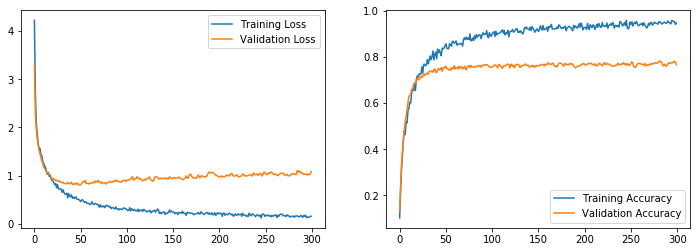

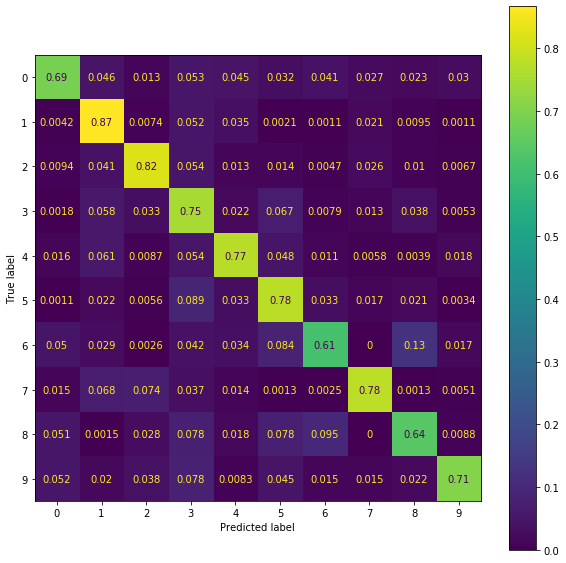

In [18]:
plot_eval_model(history, model_cnn3, X_test, y_test)

In [19]:
model_cnn3 = keras.models.load_model('../Models/vggmodels_python/vgg_3stage_CIFAR_small.h5')
# model_cnn3.summary()

# Freeze the layers except the last 15 layers
for layer in model_cnn3.layers[:-15]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_cnn3.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdb017f73d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb017f7220> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb3aaa1970> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb017e0e20> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb017e0fd0> False
<tensorflow.python.keras.layers.core.SpatialDropout2D object at 0x7fdb017e0a30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdb017d12e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb017d13a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb017d1430> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb017854c0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb01785eb0> False
<tensorflow.python.keras.layers.core.Spati

In [20]:
# remove first layer, i.e. the input
model_cnn3.layers.pop(0)

# our input has a different shape, 32x32x3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation(inputs)

# pass the augmented input to the rest of the model
outputs = model_cnn3(augmented)

# build the model, and print the summary
model_cnn3 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_8')
model_cnn3.summary()

Model: "SVHN_cnn_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
simple_vgg (Functional)      (None, 10)                2386674   
Total params: 2,386,674
Trainable params: 2,379,658
Non-trainable params: 7,016
_________________________________________________________________


In [21]:
model_cnn3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn3.fit(X_train, y_train,
                        batch_size=64,
                        epochs=300,
                        validation_data=(X_test, y_test))

300
16/16 [==============================] - 3s 174ms/step - loss: 0.1628 - accuracy: 0.9520 - val_loss: 0.8503 - val_accuracy: 0.7994
Epoch 164/300
16/16 [==============================] - 3s 170ms/step - loss: 0.1426 - accuracy: 0.9542 - val_loss: 0.8603 - val_accuracy: 0.7988
Epoch 165/300
16/16 [==============================] - 3s 174ms/step - loss: 0.1184 - accuracy: 0.9629 - val_loss: 0.8405 - val_accuracy: 0.8095
Epoch 166/300
16/16 [==============================] - 3s 171ms/step - loss: 0.1501 - accuracy: 0.9610 - val_loss: 0.8466 - val_accuracy: 0.8078
Epoch 167/300
16/16 [==============================] - 3s 171ms/step - loss: 0.1209 - accuracy: 0.9658 - val_loss: 0.8505 - val_accuracy: 0.8055
Epoch 168/300
16/16 [==============================] - 3s 172ms/step - loss: 0.1095 - accuracy: 0.9627 - val_loss: 0.8480 - val_accuracy: 0.8048
Epoch 169/300
16/16 [==============================] - 3s 174ms/step - loss: 0.1376 - accuracy: 0.9543 - val_loss: 0.8518 - val_accuracy: 0.

313/313 - 3s - loss: 0.8964 - accuracy: 0.8087
Test loss: 0.8963689208030701
Test accuracy: 0.8087000250816345


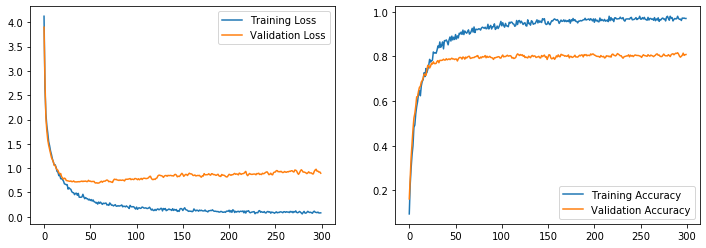

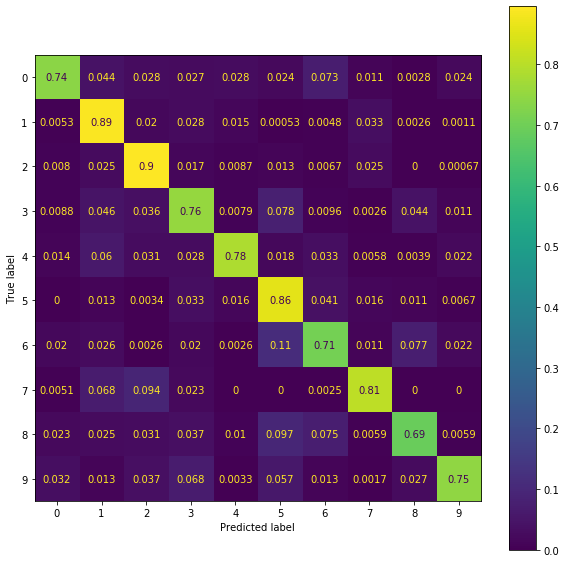

In [22]:
plot_eval_model(history, model_cnn3, X_test, y_test)

Let's try with a model trained in the MNIST Database which will make more sense for the current application

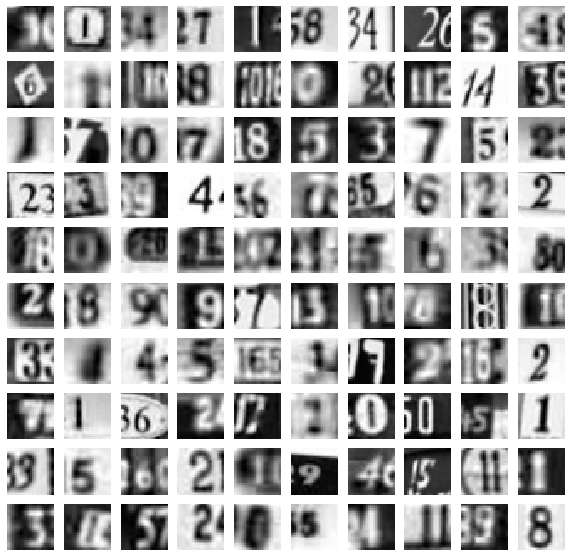

In [23]:
X_train_gray = tf.image.rgb_to_grayscale(X_train).numpy()
X_train_gray = tf.image.resize(X_train_gray, [28, 28]).numpy()
X_test_gray = tf.image.rgb_to_grayscale(X_test).numpy()
X_test_gray = tf.image.resize(X_test_gray, [28, 28]).numpy()

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(X_train_gray[i,:,:,0], cmap='gray')
    plt.axis("off")

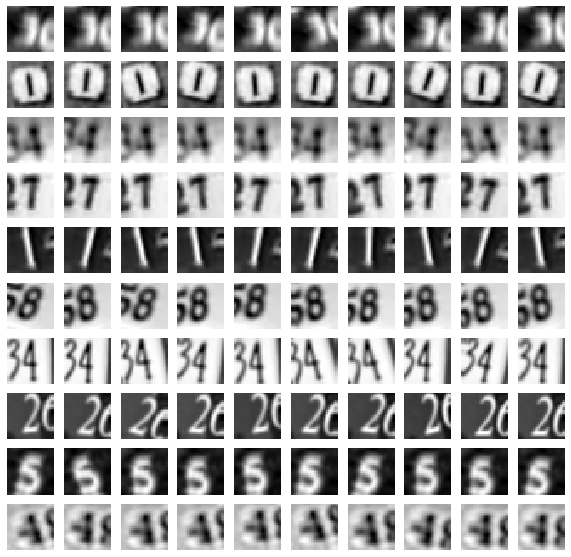

In [24]:
data_augmentation2 = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.025, 0.025)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(0.05), width_factor=(0.05))
])

fig = plt.figure(figsize=[10, 10])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation2(tf.expand_dims(X_train_gray[i,:,:,:],0))
        plt.imshow(augmented_image[0,:,:,0], cmap='gray')
        plt.axis("off")

In [25]:
model_cnn4 = keras.models.load_model('../Models/vggmodels_python/vgg_3stage_MNIST_small.h5')
model_cnn4.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_14 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 8)         0

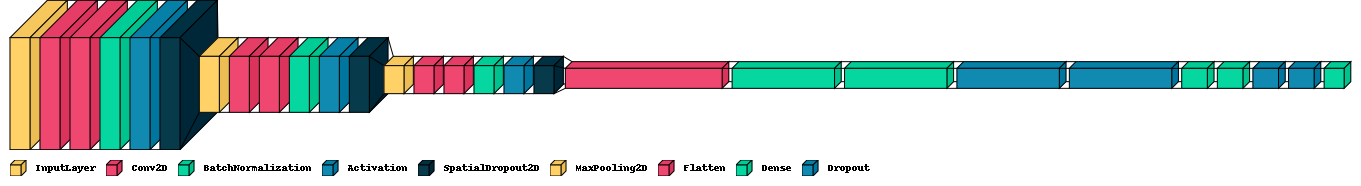

In [26]:
visualkeras.layered_view(model_cnn4, legend=True)

In [27]:
# remove first layer, i.e. the input
model_cnn4.layers.pop(0)

# our input has a different shape, 28x28x1
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation2(inputs)

# pass the augmented input to the rest of the model
outputs = model_cnn4(augmented)

# build the model, and print the summary
model_cnn4 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_9')
model_cnn4.summary()

Model: "SVHN_cnn_model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         0         
_________________________________________________________________
simple_vgg (Functional)      (None, 10)                1895010   
Total params: 1,895,010
Trainable params: 1,892,338
Non-trainable params: 2,672
_________________________________________________________________


In [28]:
model_cnn4.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn4.fit(X_train_gray, y_train,
                        batch_size=64,
                        epochs=300,
                        validation_data=(X_test_gray, y_test))

300
16/16 [==============================] - 2s 161ms/step - loss: 0.0969 - accuracy: 0.9682 - val_loss: 0.6092 - val_accuracy: 0.8673
Epoch 164/300
16/16 [==============================] - 2s 162ms/step - loss: 0.0833 - accuracy: 0.9651 - val_loss: 0.5799 - val_accuracy: 0.8659
Epoch 165/300
16/16 [==============================] - 3s 207ms/step - loss: 0.1000 - accuracy: 0.9608 - val_loss: 0.6007 - val_accuracy: 0.8560
Epoch 166/300
16/16 [==============================] - 3s 215ms/step - loss: 0.1263 - accuracy: 0.9616 - val_loss: 0.5985 - val_accuracy: 0.8538
Epoch 167/300
16/16 [==============================] - 4s 243ms/step - loss: 0.0889 - accuracy: 0.9736 - val_loss: 0.5914 - val_accuracy: 0.8634
Epoch 168/300
16/16 [==============================] - 3s 174ms/step - loss: 0.0657 - accuracy: 0.9788 - val_loss: 0.5693 - val_accuracy: 0.8683
Epoch 169/300
16/16 [==============================] - 3s 166ms/step - loss: 0.0572 - accuracy: 0.9762 - val_loss: 0.5703 - val_accuracy: 0.

313/313 - 2s - loss: 0.6864 - accuracy: 0.8701
Test loss: 0.6863842010498047
Test accuracy: 0.8701000213623047


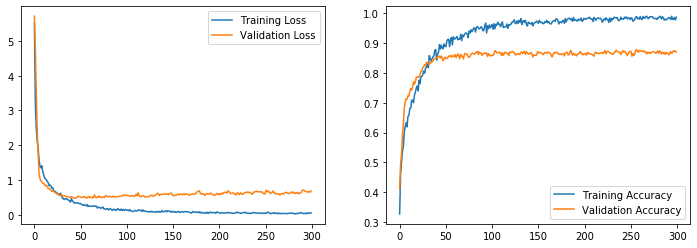

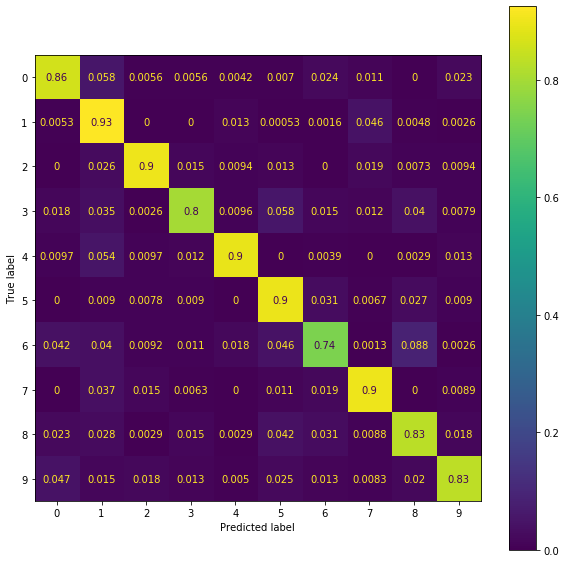

In [29]:
plot_eval_model(history, model_cnn4, X_test_gray, y_test)

In [30]:
model_cnn4 = keras.models.load_model('../Models/vggmodels_python/vgg_3stage_MNIST_small.h5')
# model_cnn3.summary()

# Freeze the layers except the last 15 layers
for layer in model_cnn4.layers[:-15]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_cnn4.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdb38463cd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb38463760> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb38077820> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb3805e2b0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb017c66a0> False
<tensorflow.python.keras.layers.core.SpatialDropout2D object at 0x7fdb58c9bb20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdb380791c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb38079fa0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdb38070e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdb38070c40> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fdb01781820> False
<tensorflow.python.keras.layers.core.Spati

In [31]:
# remove first layer, i.e. the input
model_cnn4.layers.pop(0)

# our input has a different shape, 28x28x1
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# pass the input to our augmenter
augmented = data_augmentation2(inputs)

# pass the augmented input to the rest of the model
outputs = model_cnn4(augmented)

# build the model, and print the summary
model_cnn4 = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model_10')
model_cnn4.summary()

Model: "SVHN_cnn_model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         0         
_________________________________________________________________
simple_vgg (Functional)      (None, 10)                1895010   
Total params: 1,895,010
Trainable params: 1,888,138
Non-trainable params: 6,872
_________________________________________________________________


In [32]:
model_cnn4.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = model_cnn4.fit(X_train_gray, y_train,
                        batch_size=64,
                        epochs=300,
                        validation_data=(X_test_gray, y_test))

300
16/16 [==============================] - 2s 125ms/step - loss: 0.1858 - accuracy: 0.9488 - val_loss: 0.6840 - val_accuracy: 0.8386
Epoch 164/300
16/16 [==============================] - 2s 119ms/step - loss: 0.1795 - accuracy: 0.9478 - val_loss: 0.6956 - val_accuracy: 0.8408
Epoch 165/300
16/16 [==============================] - 2s 116ms/step - loss: 0.2283 - accuracy: 0.9212 - val_loss: 0.6926 - val_accuracy: 0.8459
Epoch 166/300
16/16 [==============================] - 2s 117ms/step - loss: 0.1822 - accuracy: 0.9546 - val_loss: 0.6766 - val_accuracy: 0.8426
Epoch 167/300
16/16 [==============================] - 2s 116ms/step - loss: 0.1795 - accuracy: 0.9381 - val_loss: 0.6797 - val_accuracy: 0.8411
Epoch 168/300
16/16 [==============================] - 2s 119ms/step - loss: 0.1730 - accuracy: 0.9461 - val_loss: 0.6534 - val_accuracy: 0.8439
Epoch 169/300
16/16 [==============================] - 2s 119ms/step - loss: 0.1721 - accuracy: 0.9400 - val_loss: 0.6513 - val_accuracy: 0.

313/313 - 2s - loss: 0.7258 - accuracy: 0.8472
Test loss: 0.7257581353187561
Test accuracy: 0.8471999764442444


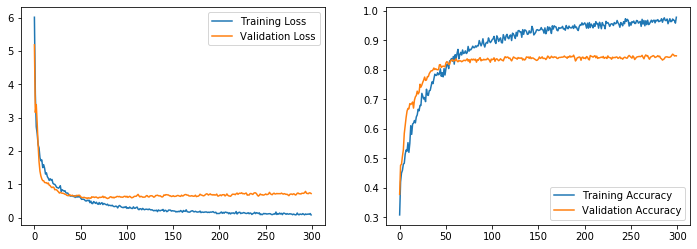

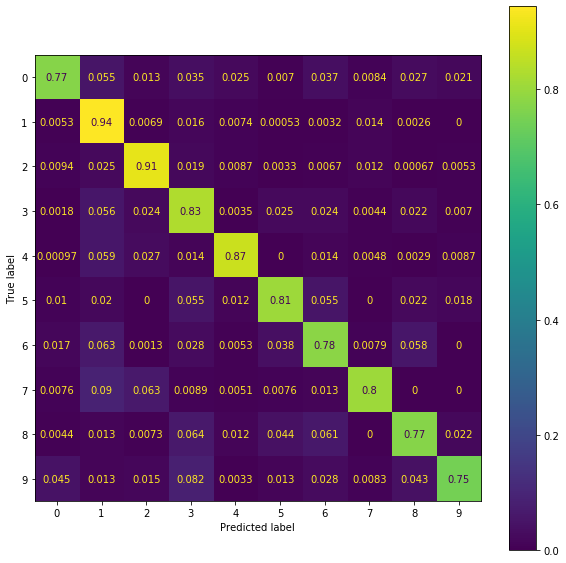

In [33]:
plot_eval_model(history, model_cnn4, X_test_gray, y_test)